# DS 325 - Week 02 - HW


## Learning Goal  
The goal of this notebook is to get hands-on experience and intuition about gradient descent, linear regression and regularization. We once again emphasize the difference between fitting and predicting. We will see that it is much more difficult to get good out-of-sample performance on a test set (predicting) than it is to get good in-sample performance on the training set (fitting).


# Gradient Descent

Linear regression - With so many algorithms to choose from, how do you decide?

In the previous class, we used the normal equation to find the inverse of **$X^T X$** which has dimensions $(n+1)\times(n+1)$.  The number of operations (+,-,*,/) or **computational cost** need to compute this depends on the **dimensions** of the matrix and the **algorithm**.  

* To invert the matrix, the computational cost is $O(n^3)$. 
* The use LinearRegression the cost is $O(n^2)$.  LinearRegression uses SVD (Singular Value Decomposition, $X =  U \Sigma V$, where we have _factored_ $X$ into a scaling $\Sigma$ and eigenvectors $V$)  
* The difference here is significant, with twice the features ($2n$) the computational cost (and time) to invert is 4 times greater than SVD


Gradient descent is an optimization algorithm used to find the values of parameters (coefficients) of a function (f) that minimizes a cost function (cost).

Gradient descent is best used when the parameters cannot be calculated analytically (e.g. using linear algebra) and must be searched for by an optimization algorithm.

In [32]:
# some functions we will use
def myPlotContours(ax,x,y,trange0,trange1,lvls):    
    T0, T1 = np.meshgrid(np.linspace(trange0[0],trange0[1],50),np.linspace(trange1[0],trange1[1],50)) #input the range of theta0, theta1 to find the contour
    #Computing the cost function for each theta combination
    Xb     = np.vstack((np.ones(y.shape[0]), x)).transpose()   #make X= [1,x]
    # compute the MSE over the range of theta0,theta1
    zs = np.array(  [getMSE(Xb, y,np.array([t0,t1])) 
                         for t0, t1 in zip(T0.ravel(), T1.ravel()) ] )
    Z = zs.reshape(T0.shape)
    line_c = ax.contour(T0, T1, Z,lvls,norm=LogNorm())#, norm=LogNorm())    
    ax.clabel(line_c,colors=['black'],manual=False, inline=True,rightside_up=True,  fmt=' {:.1f} '.format)
def predict(x,theta):
    X     = np.vstack((np.ones_like(x), x)).transpose() #make X= [1,x]
    return X.dot(theta)
def getMSE(X,y,theta):
    return np.mean((y-X.dot(theta))**2)**0.5
def gradientDescent(x, y, theta, alpha, Niterations):
    N     = y.shape[0]  
    X     = np.vstack((np.ones(N), x)).transpose() #make X= [1,x]
    theta_hist=[]
    J_hist= []
    for i in range(Niterations):
        y_estimate = X.dot(theta)
        error      = (y - y_estimate)      #this is a vector of residuals  
        gradient   = -(1.0/N) * error.dot(X)        
        theta      = theta - alpha * gradient   #update theta
        err        = getMSE(X,y,theta)     #update the error
        theta_hist.append(theta)
        J_hist.append(err)
        if (err>1e20 or np.isnan(err) or np.isinf(err)): #our algorithm has diverged/crashed
            break
    theta_hist = np.array(theta_hist)
    J_hist = np.array(J_hist)
    return theta,J_hist
def sgdRMSprop(x, y, theta, alpha, Niterations,batchSize=None):
    gamma = 0.9
    eps   = 1e-8 #avoid divide by zero
    N     = y.shape[0]  
    if (batchSize==None or batchSize>N): batchSize = N;
    X     = np.vstack((np.ones(N), x)).transpose() #make X= [1,x]
    v     = np.zeros(theta.shape)
    err0  = getMSE(X,y,theta)
    theta_hist=[]
    J_hist= []
    for i in range(Niterations):
        indexs     = np.random.permutation(N)
        indj       = indexs[:batchSize]
        y_estimate = X[indj].dot(theta)
        error      = (y[indj] - y_estimate)        
        gradient   = -(1.0/batchSize) * error.dot(X[indj])
        v          = gamma * v + (1.-gamma) * gradient**2
        theta      = theta - alpha * gradient / (eps + np.sqrt(v))
        err        = getMSE(X,y,theta)
        if (err>1e20 or np.isnan(err) or np.isinf(err)): #our algorithm has diverged/crashed
            break
        theta_hist.append(theta)
        J_hist.append(err)
    theta_hist = np.array(theta_hist)
    J_hist = np.array(J_hist)
    return theta,J_hist

## Least squares linear regression: 

For ordinary least square regression (no regularization), we minimize the square loss cost function:

$$
\operatorname{min} J(\theta) = \operatorname{min} ||X \theta-\textbf{y}||_2^2 = \operatorname{min} (X \theta-y)^T(X \theta-y)
$$

If features $X$ are linearly independent, then there exists unique solution to this problem:

$$
\hat{\theta}= (X^T X)^{-1} X^T y
$$

## Ridge Regression
In Ridge-Regression, the regularization penalty is taken to be the L2-norm of the parameters

$$
\operatorname{min} J_{ridge}(\theta) = \operatorname{min} ||X \theta-y||_2^2 + \alpha ||\theta||_2^2
$$

Notice that the parameter $\alpha$ controls how much we weigh the fit and regularization term.

## LASSO ##

We will also be interested in the case where the penalty is the L1-norm of the parameters (sum of absolute values of parameters). This is called LASSO.

$$
\operatorname{min} J_{lasso}(\theta) = \operatorname{min} ||X \theta-y||_2^2 + \alpha ||\theta||_1
$$

As we discussed in class, LASSO tends to give sparse solution. Below, we're going to explore these ideas a little bit more.


# Exercises

Exercises on gradient descent.


## Exercise 1: batch size from poor starting $\theta_{start}$

In the Exercise 1 space below, use the **lungs.csv** to repeat the analysis using **height** instead of age.

* Plot the data (y vs x) and the fit lines (best fit and SGD)

* Keep the Nitinterations fixed at 100 and $\theta_{start} = [5,5]$
* We are going to explore how batchSize affects the convergence.
* Choose one batchSize equal to the full dataset, and a second much smaller batchSize = 10
* vary its learning rate **$\alpha$ > 0**, as we did in class. **Choose an appropriate range to examine how it might play a role.**  Start with $\alpha$ between $10^{0}$ and $10^{-1}$, and expand it until the effect is clear.  You can use about 10-20 alpha, any more (or less) is likely unnecessary.
* Plot MSE v $\alpha$ for batchSize=10 and the fullsize of the dataset on the same plot.
    * What happens if it is very small or if it is very big? Report the range for _good_ $\alpha$.
    * How did the results depend on batchSize?    

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns; 
sns.axes_style("whitegrid")
sns.set_context("paper")
from sklearn.linear_model import SGDRegressor
np.random.seed(325)

In [34]:
#get new x (height) and y (FEV)
# web_path = '' #if downloaded data to the current folder
web_path = 'http://public.gettysburg.edu/~jpuckett/ds325/data/' #if using data over web
df = pd.read_csv(web_path+'lungs.csv')
x = df["ht"]
y = df["FEV"]

In [35]:
theta = np.array([5,5])
Niterations = 100
alpha = 0.1
# (thetaGD, c) = gradientDescent(x,y,theta,alpha, Niterations)
(thetaGD, c) = sgdRMSprop(x,y,theta,alpha, Niterations)


In [36]:
X = np.vstack((np.ones_like(x), x)).transpose()
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
err_best = np.mean((y-X.dot(theta_best))**2)**0.5


Text(0, 0.5, 'FEV [L]')

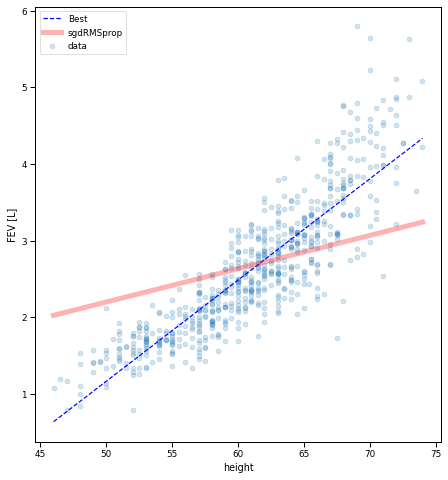

In [37]:
fig = plt.figure(figsize = (16,8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(x, y, alpha=0.2,label='data')
xp = np.linspace(np.min(x),np.max(x),10)
yp = predict(xp,thetaGD)
yb = predict(xp,theta_best)
ax1.plot(xp, yb, 'b--',label='Best')
ax1.plot(xp, yp, 'r-',label='sgdRMSprop',linewidth=5,alpha=0.3)
plt.legend()
ax1.set_xlabel('height')
ax1.set_ylabel('FEV [L]')

In [38]:
#try different alpha using sgdRMSprop
theta  = np.array([5,5])
Niterations = 100

#rest of your code below, choose appropriate range for alpha
alphas = np.logspace(-2, 2, 40)

In [39]:
batchSize = y.shape[0]
print('full batch: %f'%(batchSize))
cost_a0 = np.zeros(alphas.shape)

for i,a in enumerate(alphas):
    (thetaS, c) = sgdRMSprop(x,y,theta,a, Niterations,batchSize)
    cost_a0[i] = c[-1]
    # print(i,a,thetaS,cost_a0[i])

full batch: 654.000000


In [40]:
batchSize_small = 10
cost_a1 = np.zeros(alphas.shape)

for i,a in enumerate(alphas):
    (thetaS, c) = sgdRMSprop(x,y,theta,a, Niterations,batchSize_small)
    cost_a1[i] = c[-1]
    # print(i,a,thetaS,cost_a1[i])

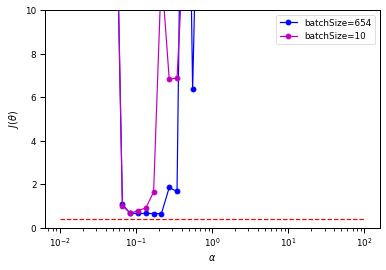

In [41]:
#plot the cost v alpha for each batch-size
plt.plot(alphas,cost_a0,'bo-',label='batchSize=%d'%batchSize)
plt.plot(alphas,cost_a1,'mo-',label='batchSize=%d'%batchSize_small)
plt.xlabel(r'$\alpha$') 
plt.ylabel(r'$J(\theta)$')
plt.xscale('log')
plt.plot(alphas,err_best*np.ones(alphas.shape),'r--')
plt.ylim([0,10])
plt.legend()
plt.show()



#### Comment on result
I run alpha from $10^{-2}$ to $10^2$ with 40 alphas in total
The plot shows that:
- If $\alpha < 10^{-1.1}$, $\theta$ does not evolve enough to significantly decrease the loss function $J(\theta)$
- When use mini-batch, $\theta$ will be evolve enough to significantly decrease the loss function $J(\theta)$ for $\alpha$ at about $10^{-1}$. $\theta$ starts to diverge when $\alpha$ is greater than that.
- When use full-size batch, $\theta$ will be evolve enough to significantly decrease the loss function $J(\theta)$ for widerer range of $\alpha$: from $10^{-1}$ to $10^{-0.5}$. If $\alpha > 10^{0.5}$, $\theta$ starts to diverge

## Exercise 2: iterations from poor $\theta_{start}$ examine how iterations matter.

In the Exercise space below, we'll use the same data as Exercise 1 (the **lungs.csv** fitting **FEV** vs **height**)

* Nore we'll explore the affect of Niterations and convergence.

* Use a constant batchSize=10 and $\theta_{start} = [5,5]$
* Choose Nitinterations = 50 and Nitinterations = 1000
* vary its learning rate **$\alpha$ > 0**, as we did in class, somewhere around $10^-3$ to 10 should be appropriate.
 

In [42]:
web_path = 'http://public.gettysburg.edu/~jpuckett/ds325/data/' #if using data over web
df = pd.read_csv(web_path+'lungs.csv')
#try different theta0
x = df["ht"]
y = df["FEV"]
theta  = np.array([5,5])
Niterations0 = 50
Niterations1 = 1000
batchSize = 10
#rest of your code below


In [43]:
X = np.vstack((np.ones_like(x), x)).transpose() #make X= [1,x]
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) #
err_best = np.mean((y-X.dot(theta_best))**2)**0.5


In [44]:
alphas = np.logspace(-3, 1, 40)

In [45]:
cost_a0 = np.zeros(alphas.shape)

for i,a in enumerate(alphas):
    (thetaS, c) = sgdRMSprop(x,y,theta,a, Niterations0,batchSize)
    cost_a0[i] = c[-1]
    # print(i,a,thetaS,cost_a1[i])

In [15]:
cost_a1 = np.zeros(alphas.shape)

for i,a in enumerate(alphas):
    (thetaS, c) = sgdRMSprop(x,y,theta,a, Niterations1,batchSize)
    cost_a1[i] = c[-1]
    # print(i,a,thetaS,cost_a1[i])

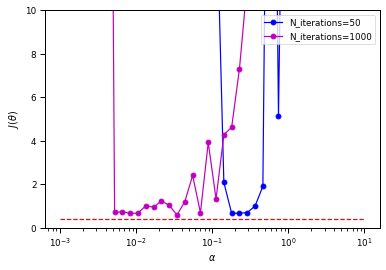

In [16]:
#plot the cost v alpha for each batch-size
plt.plot(alphas,cost_a0,'bo-',label='N_iterations=%d'%Niterations0)
plt.plot(alphas,cost_a1,'mo-',label='N_iterations=%d'%Niterations1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$J(\theta)$')
plt.xscale('log')
plt.plot(alphas,err_best*np.ones(alphas.shape),'r--')
plt.ylim([0,10])
plt.legend()
plt.show()



#### comment on your results, compare w/ Exercise 1
- For 1000 iters, the $\alpha$ we need to converge ranges from smaller then $10^{-2}$ to about $10^{-1.5}$
- For 50 iters, the $\alpha$ we need to converge ranges from around then $10^{-0.7}$ to about $10^{-0.5}$

Therefore, for a suffivent number of iters, we have a wider range of $\alpha$ to choose to converge

**Comment**
With enough iterations, even very small alpha converge to a good local minimum. There is no need to be so choosey over $\alpha$.

Early stopping (small N iterations), requires $\alpha$ chosen wisely in that small window near 0.5.  

### Exercise 3

Answer the following questions.

a) Do all gradient descent algorithms lead to the same model, provided you let them run long enough?

b) Suppose the features in your training set have very different scales.  Which algorithms might suffer from this? What can you do about it?


#### your response here

a)
- In general, these GD algorithms all return the gobal optimum if we choose suitable hyperparameters (alpha in this case).
- However, SGD and mini-batch GD use randomness which means that they approach the global optimum, but they don't converge. One way to help them converge is to gradually reduce the learning rate hyperparameter.
- Also, since randomness is good to escape from local optima, it helps SGD reaches the global minimum easier than full-size Batch GD

b)
- The cost function will have the shape of an oval, so GD algorithms will take a long time to converge. To solve this, we need to scale the data.
- The Normal Equation, however, workd fine without scaling since it does not require normalizing the features

## Regularization exercises

For these exercises, you will both add on to this Jupyter Notebook to show your work after each corresponding code block comment below. 

Using the **yacht.csv**, complete the following exercises.

[https://archive.ics.uci.edu/ml/datasets/yacht+hydrodynamics](https://archive.ics.uci.edu/ml/datasets/yacht+hydrodynamics)

## load libraries

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
# Load dataset
web_path = 'http://public.gettysburg.edu/~jpuckett/ds325/data/' #if using data over web
#web_path = '' #if downloaded data to the current folder
df2 = pd.read_csv(web_path+'yacht.csv')
df2.head()

,Longitudinal_position,Prismatic_coefficient,Length-displacement,Beam-draught,Length-beam,Froude,Residuary_resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


### Exercise 4 - Regularization with Ridge Regression

Use the methods we went through in class to evaluate a model using Ridge regression, were we are examing how features affect the Residuary_resistance. 

For the test/train split use: 
<code>
    X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=1)
</code>    


* Plot coefficients as a function of $\alpha$.  Label the axes and give a legend with the features.
* Plot $MSE$ as a function of $\alpha$.  
* Which predictor(s) turned out to be important in the final model(s)?


In [18]:
#make X and y from dataframe
X = df2.drop(['Residuary_resistance'], axis = 1).astype('float64')
y = df2[['Residuary_resistance']]
#make X_train,y_train,X_test,y_test
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=1)

In [19]:
alphas = np.logspace(-3,5,1000)

In [20]:
# run ridge regression for alphas
ridge = Ridge(normalize = True)
coefs = []
mses = []

for a in alphas:
    ridge.set_params(alpha = a) #alpha
    ridge.fit(X_train, y_train) #fit
    coefs.append(ridge.coef_)    #save coefficients
    pred = ridge.predict(X_test)  #find predicitions
    mses.append(mean_squared_error(y_test, pred) ) #save the MSE
#
coefs = np.array(coefs).reshape(alphas.shape[0],-1)
mses = np.array(mses).reshape(alphas.shape[0],-1)

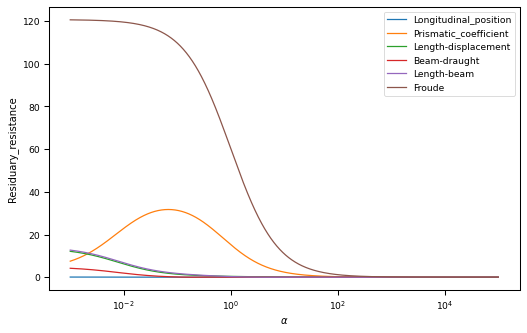

In [21]:
#plot coef for ridge regression as a function of alpha
fig, ax = plt.subplots(figsize=(8.1, 5),dpi= 75)
ax.plot(alphas, np.abs(coefs))
# ax.plot(alphas, np.array(coefs))
ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel('Residuary_resistance')
plt.legend(X.columns)
plt.show()

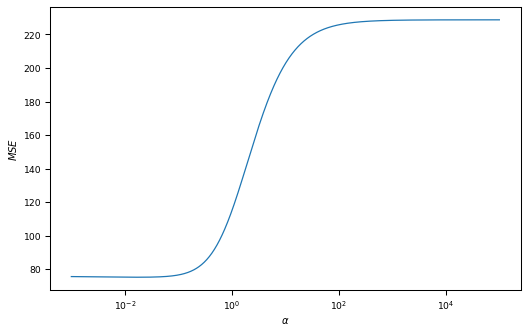

In [22]:
#plot MSE
fig, ax = plt.subplots(figsize=(8.1, 5),dpi= 75)
ax.plot(alphas, mses)
ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$MSE$')
plt.show()

In [23]:
#which is the best alpha?

### nice function to find best alpha
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
print("alpha_best = %4f"%ridgecv.alpha_)

alpha_best = 0.064537


In [24]:
#what are the coefficients of your ridge model using the best alpha?

ridge4 = Ridge(alpha = ridgecv.alpha_)
ridge4.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred4 = ridge4.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge4.coef_[0], index = X.columns)) # Print coefficients
print("R2  = %4f"%(ridge4.score(X_test,y_test)))
print("MSE = %4f"%mean_squared_error(y_test, pred4)) 

Longitudinal_position      0.065892
Prismatic_coefficient     -5.546712
Length-displacement       11.464756
Beam-draught              -3.983004
Length-beam              -11.975830
Froude                   117.236787
dtype: float64
R2  = 0.668193
MSE = 75.646688


#### your final comments here

### Exercise 5 - Regularization with Lasso:

* Here we continue a similar analysis as in Exercise 4, but now consider Lasso regularization.
* $\alpha$: use a wide range here about $0.0001$ to $10000$.

* Plot coefficients as a function of $\alpha$, again using a legend to give the features of these weights.
* Plot $MSE$ as a function of $\alpha$
* Which predictors turned out to be important in the final model(s)?




In [25]:
#get the initial train,test split of data
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.3,random_state=1)
#make sure your test set is the same for all training sizes, below

In [26]:
alphas = np.logspace(-4,4,500) # 10**-4 to 10**4

In [27]:
# run lasso regression for alphas
lasso = Lasso(max_iter = 1000)   # if max_iter = 100, error: Objective did not converge
coefs = []
mses = []

for a in alphas:
    lasso.set_params(alpha = a)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)
    pred = lasso.predict(scale(X_test))
    mses.append(mean_squared_error(y_test, pred) )
#
coefs = np.array(coefs).reshape(alphas.shape[0],-1)
mses = np.array(mses).reshape(alphas.shape[0],-1)

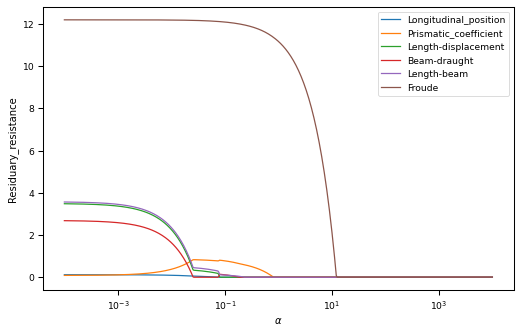

In [28]:
#plot coef for lasso regression as a function of alpha
fig, ax = plt.subplots(figsize=(8.1, 5),dpi= 75)
ax.plot(alphas, np.abs(coefs))
# ax.plot(alphas, np.array(coefs))
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel(r'$\alpha$')
plt.ylabel('Residuary_resistance')
plt.legend(X.columns)
plt.show()

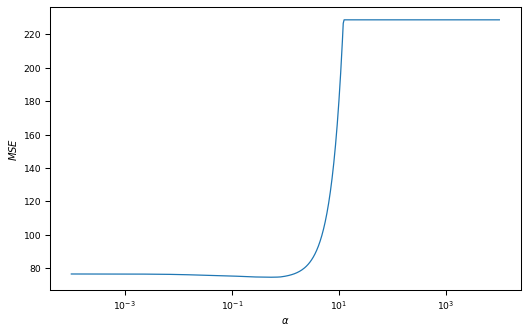

In [29]:
#plot MSE
fig, ax = plt.subplots(figsize=(8.1, 5),dpi= 75)
ax.plot(alphas, mses)
ax.set_xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$MSE$')
plt.show()

In [30]:
#which alpha was the best?
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(scale(X_train), np.ravel(y_train))
print("alpha_best = %4f"%lassocv.alpha_)

alpha_best = 0.323172


In [31]:
#what are the coefficients of Lasso at that best alpha?

lasso.set_params(alpha=lassocv.alpha_)
pred5 = lassocv.predict(scale(X_test))
print(pd.Series(lassocv.coef_, index = X.columns)) # Print coefficients
print("R2  = %4f"%(lassocv.score(scale(X_test),y_test)))
print("MSE = %4f"%mean_squared_error(y_test, pred5)) 

Longitudinal_position     0.000000
Prismatic_coefficient    -0.496357
Length-displacement       0.000000
Beam-draught              0.000000
Length-beam              -0.000000
Froude                   11.853354
dtype: float64
R2  = 0.672815
MSE = 74.592782


With Lasso, only Froude number plays a large role.  The weights of other features have shrunk.  

### Exercise 6

a. Did you expect ridge regression to outperform the lasso, or vice versa?

b. Which predictors turned out to be important in the final model(s)?

c. Do you think LASSO and Ridge Regression will give qualitatively different answers? (Consider the limits $\alpha=0$  and $\alpha\rightarrow\infty$)

**Answer**

a.

- In Ridge, the gradients get smaller as the parameters approach the global optimum, so Gradient Descent naturally slows down, which helps convergence (as there is no bouncing around like Lasso). Second, the optimal parameters get closer and closer to the origin when you increase $\alpha$, but they never get eliminated entirely.

- When we are not sure which features are the most important ones, we should use Lasso since it pushes the weights down to exactly zero, a feature selection.
models

b. 
- Using Lasso, those features that are not set to 0 will be the important predictors for the model
- Using Ridge, we can recognise which features are more important than others, so we can choose predictors from the result of Ridge

c.
- For Ridge:
    1. If $\alpha \rightarrow 0$: we haev same coeficients simple linear regression
    2. If $\alpha \rightarrow \infty$: coeficients approach 0, leading to flatter, less extreme, and more reasonable prediction which reduce the model’s variance but increasing its bias. As 

- For Lasso:
    1. If $\alpha \rightarrow 0$: we have same coefficients as simple linear regression
    2. If $\alpha \rightarrow \infty$: it eliminates the weights of the least important features (set to 0) which peforms feature selection and creates a sparse model
